# Ultrasonic Data Feature Engineering

Export sensor data 1-6 and merge them and fill up NaNs

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
def get_all_files_in_directory(root_directory):
    file_paths = []
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths


def merge_csv_files(file_paths):
    """
    Merge multiple CSV files into a single DataFrame.

    Parameters:
    file_paths (list of str): List of file paths to the CSV files.

    Returns:
    DataFrame: Merged DataFrame containing data from all input CSV files.
    """
    dataframes = []
    for file in file_paths:
        df = pd.read_csv(file)
        dataframes.append(df)

    # Concatenate all DataFrames
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    return merged_df

## Import data

Currently there are 20 sensor datas.

In [6]:
folder_path = '../../ultra_sonic_sensor/fully_automate/data_v4.1.1'
file_paths = get_all_files_in_directory(folder_path)
df_data_v4_1_1 = merge_csv_files(file_paths)
df_data_v4_1_1

,Trial,Ping Duration,Distance (cm),Ping Time (us),Delay (us),Steps,Arduino ID,Sensor ID,Range (cm),Sensor length (cm),...,side a (cm),side b (cm),side c (cm),Angle on YZ plane,Sensor Configuration,Sensor Angle,Surface material,Surface Length (cm),Surface Width (cm),side g (cm)
0,0,1668,13.11,747,16800,10440.0,1,100,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
1,1,1688,13.60,775,16800,10440.0,1,100,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
2,2,1680,13.18,751,16800,10440.0,1,100,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
3,3,1664,13.18,751,16800,10440.0,1,100,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
4,4,1696,13.67,779,16800,10440.0,1,100,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218176,45,6520,52.75,3007,3000,0.0,1,99,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
218177,46,6520,52.61,2999,3000,0.0,1,99,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
218178,47,6544,53.04,3023,3000,0.0,1,99,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
218179,48,6544,53.11,3027,3000,0.0,1,99,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN


Clean data

In [7]:
# Step 1: Identify Columns with NaNs
nan_columns = df_data_v4_1_1.columns[df_data_v4_1_1.isnull().any()]

# Step 2: Find Mode and Replace NaNs
for col in nan_columns:
    if df_data_v4_1_1[col].dtype == object:  # Check if the column is categorical
        mode_value = df_data_v4_1_1[col].mode()[0]  # Find the mode value (most frequent value)\
        df_data_v4_1_1[col].fillna(mode_value, inplace=True)  # Replace NaNs with the mode value

df_data_v4_1_1["Color of sensor"] = df_data_v4_1_1["Color of sensor"].str.lower()

In [8]:
values_to_keep = [16800,10000,8000,6000,3000]
df_data_v4_1_1 = df_data_v4_1_1[df_data_v4_1_1["Delay (us)"].isin(values_to_keep)]

# Feature Engineering:  Add IQR Range_delay

Helper codes

In [9]:
def identify_and_remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    df_outliers_lower = df[(df[column] <= lower_bound)]
    df_outliers_upper = df[(df[column] >= upper_bound)]
    return df_no_outliers,df_outliers_lower,df_outliers_upper

def split_quartiles(df):
    # Group the data by 'Sensor ID', 'Delay (us)', and 'Range (cm)'
    df_copy = df.copy()
    grouped = df_copy.groupby(['Sensor ID', 'Delay (us)', 'Range (cm)'])

    # Identify and remove outliers for each group
    middle_quartile = []
    lower_quartile = []
    upper_quartile = []

    for name, group in grouped:
        cleaned_group = group.copy()
        for column in ['Ping Time (us)']:
            middle_quartile_group,lower_quartile_group,upper_quartile_group = identify_and_remove_outliers(cleaned_group, column)
        middle_quartile.append(middle_quartile_group)
        lower_quartile.append(lower_quartile_group)
        upper_quartile.append(upper_quartile_group)
    # Combine the cleaned groups into a single DataFrame
    df_middle_quartile= pd.concat(middle_quartile)
    df_lower_quartile = pd.concat(lower_quartile)
    df_upper_quartile = pd.concat(upper_quartile)
    
    return df_middle_quartile, df_lower_quartile, df_upper_quartile


def create_range_delay_feature(df_quartile,bound):
    # Step 1: Group and calculate mean
    df_grouped = df_quartile.groupby(['Sensor ID', 'Range (cm)', 'Delay (us)'])['Ping Time (us)'].mean().reset_index()

    # Step 2: Create `range_delay` column
    df_grouped['range_delay'] = df_grouped['Range (cm)'].astype(str) + '_' + df_grouped['Delay (us)'].astype(str)+'_'+'mean'+'_'+bound

    # Step 3: Pivot the table
    df_pivot = df_grouped.pivot(index='Sensor ID', columns='range_delay', values='Ping Time (us)').reset_index()
    
    return df_pivot

In [10]:
df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df_data_v4_1_1)

In [11]:
df_middle_quartile.groupby(['Sensor ID','Range (cm)', 'Delay (us)'])['Ping Time (us)'].mean().reset_index(["Delay (us)","Range (cm)"])

,Range (cm),Delay (us),Ping Time (us)
Sensor ID,,,
32,13,3000,765.640000
32,13,6000,765.560000
32,13,8000,766.120000
32,13,10000,765.626263
32,13,16800,765.693878
...,...,...,...
108,53,3000,3034.282051
108,53,6000,3043.240000
108,53,8000,3035.105263


In [12]:
create_range_delay_feature(df_middle_quartile,"middle")

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_middle,48_16800_mean_middle,48_3000_mean_middle,48_6000_mean_middle,48_8000_mean_middle,53_10000_mean_middle,53_16800_mean_middle,53_3000_mean_middle,53_6000_mean_middle,53_8000_mean_middle
0,32,765.626263,765.693878,765.640000,765.560000,766.120000,1057.280000,821.200000,1057.626263,1057.440000,...,2765.200000,2771.200000,2765.315789,2765.520000,2765.160000,3090.111111,3088.120000,3090.480000,3089.560000,3090.000000
1,33,755.000000,779.530612,736.640000,779.275862,755.467532,1024.818182,1035.640000,1024.777778,1025.720000,...,2725.800000,2726.920000,2739.000000,2729.600000,2729.040000,3040.480000,3016.896907,3042.000000,3047.571429,3049.026667
2,34,665.680000,658.920000,675.989247,653.682353,665.240000,969.480000,969.469136,969.520000,969.585859,...,2641.160000,2640.979798,2643.360000,2642.040000,2641.480000,2941.040000,2940.920000,2944.301205,2939.960000,2948.090909
3,35,861.640000,861.626263,804.320000,861.840000,863.000000,1012.333333,1011.800000,1012.720000,1012.240000,...,2755.000000,2777.813187,2755.000000,2777.595745,2755.418605,3014.760000,3015.720000,3029.800000,3029.813187,3017.120000
4,36,743.520000,743.962025,743.360000,743.680000,743.600000,1067.000000,1054.880000,1064.494949,1067.000000,...,2770.083333,2753.960000,2763.160000,2754.680000,2769.608696,3085.712644,3077.440000,3043.560000,3047.903226,1856.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,104,759.000000,759.816327,759.244898,759.000000,759.000000,1049.800000,1050.836735,1049.560000,1050.200000,...,2751.975610,2743.320000,2743.800000,2740.440000,2741.720000,3021.421053,3028.120000,3045.545455,3034.920000,3034.920000
73,105,712.600000,28938.660000,713.880000,713.240000,719.000000,1008.680000,1018.360000,1009.086957,1009.938776,...,2712.360000,2714.200000,2711.560000,2703.100000,2719.960000,2999.240000,3007.947368,3003.240000,2994.520000,2999.560000
74,106,673.122449,672.025641,672.840000,672.680000,672.120000,962.288889,941.240000,962.487179,963.000000,...,2645.916667,2589.000000,2648.666667,2670.255814,2659.880000,2957.800000,1162.750000,4235.980000,2957.829268,2956.957447
75,107,694.280000,686.920000,695.000000,693.480000,693.893617,987.408163,959.700000,987.000000,987.000000,...,2658.040000,2595.916667,2659.160000,2657.160000,2649.880000,2955.640000,1858.255814,2956.333333,2954.346939,2955.000000


In [13]:
def feature_engineering_quartile_means(df):
    df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df)
    df_range_delay_middle = create_range_delay_feature(df_middle_quartile,"middle")
    df_range_delay_lower = create_range_delay_feature(df_lower_quartile,"lower")
    df_range_delay_upper = create_range_delay_feature(df_upper_quartile,"upper")

    # List of DataFrames
    df_pivots = [df_range_delay_middle, df_range_delay_lower, df_range_delay_upper]

    # Initialize the merged DataFrame with the first DataFrame in the list
    df_range_delay_all = df_pivots[0]

    # Iteratively merge each DataFrame in the list
    for df in df_pivots[1:]:
        df_range_delay_all = df_range_delay_all.merge(df, on='Sensor ID')
        
    # Replace all NaN values with 0 in the merged DataFrame
    df_range_delay_all.fillna(0, inplace=True)

    return df_range_delay_all, df_range_delay_middle, df_range_delay_lower,df_range_delay_upper
    

df_range_delay_all,df_range_delay_middle, df_range_delay_lower,df_range_delay_upper = feature_engineering_quartile_means(df_data_v4_1_1)


The product is following now we will be conducting PCA method to reduce dimensionality

In [14]:
df_range_delay_all

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,32,765.626263,765.693878,765.640000,765.560000,766.120000,1057.280000,821.200000,1057.626263,1057.440000,...,0.000000,0.0,2787.833333,0.000000,0.000000,3099.000000,0.000000,0.000000,0.0,0.000000
1,33,755.000000,779.530612,736.640000,779.275862,755.467532,1024.818182,1035.640000,1024.777778,1025.720000,...,0.000000,0.0,2740.037037,0.000000,0.000000,0.000000,3073.666667,0.000000,3073.4,3074.000000
2,34,665.680000,658.920000,675.989247,653.682353,665.240000,969.480000,969.469136,969.520000,969.585859,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,35,861.640000,861.626263,804.320000,861.840000,863.000000,1012.333333,1011.800000,1012.720000,1012.240000,...,2758.652174,0.0,2756.839080,0.000000,2778.428571,0.000000,0.000000,0.000000,0.0,0.000000
4,36,743.520000,743.962025,743.360000,743.680000,743.600000,1067.000000,1054.880000,1064.494949,1067.000000,...,2779.000000,0.0,0.000000,0.000000,0.000000,3113.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,104,759.000000,759.816327,759.244898,759.000000,759.000000,1049.800000,1050.836735,1049.560000,1050.200000,...,2775.000000,0.0,0.000000,0.000000,0.000000,3048.333333,0.000000,3072.000000,0.0,0.000000
73,105,712.600000,28938.660000,713.880000,713.240000,719.000000,1008.680000,1018.360000,1009.086957,1009.938776,...,0.000000,0.0,0.000000,2724.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
74,106,673.122449,672.025641,672.840000,672.680000,672.120000,962.288889,941.240000,962.487179,963.000000,...,2663.000000,0.0,2671.000000,0.000000,0.000000,0.000000,2959.000000,0.000000,0.0,0.000000
75,107,694.280000,686.920000,695.000000,693.480000,693.893617,987.408163,959.700000,987.000000,987.000000,...,0.000000,2689.0,0.000000,0.000000,0.000000,0.000000,2526.000000,0.000000,0.0,2955.878049


# Conduct PCA based feature importance

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def process_PCA(df):
    # Extract features and standardize
    features = df.drop(columns='Sensor ID')
    sensor_ids = df['Sensor ID']

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Perform PCA
    pca = PCA()
    principal_components = pca.fit_transform(features_scaled)

    # Explained variance ratio for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance to see the importance of each component
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Get the loadings (coefficients) of the features on the principal components
    loadings = pca.components_

    # Display the loadings for the first few principal components
    return explained_variance, loadings, features

explained_variance, loadings, features = process_PCA(df_all)



NameError: name 'df_all' is not defined

In [ ]:
# Create a DataFrame for the loadings
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=features.columns)
loading_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77
13_10000_mean_middle,-0.073080,0.134947,0.069517,0.055249,0.074252,0.031227,0.020156,-0.066020,-0.010548,-0.050909,...,0.011872,0.051663,-0.000726,-0.015574,-0.031487,0.057976,0.000900,-0.061383,0.070959,-0.076786
13_16800_mean_middle,0.012636,-0.028459,-0.029829,-0.044694,-0.038169,-0.044346,0.231316,-0.111981,0.095856,-0.062188,...,-0.018283,0.023293,-0.003548,0.031867,0.002714,-0.007194,-0.029504,-0.005331,0.003895,0.400717
13_3000_mean_middle,-0.098213,-0.019286,0.032781,0.028458,0.060615,0.030234,0.023000,-0.073056,0.002115,-0.054033,...,0.008918,0.042390,0.032495,-0.077418,0.030672,-0.071739,0.022025,-0.027406,-0.048418,-0.123873
13_6000_mean_middle,-0.073950,0.134961,0.067486,0.060131,0.077191,0.029432,0.029317,-0.058968,-0.002851,-0.050540,...,0.022654,0.054243,-0.004501,-0.033459,-0.053248,0.009069,-0.009770,-0.006222,0.092834,0.150839
13_8000_mean_middle,-0.073258,0.134767,0.068311,0.059167,0.075676,0.031199,0.034631,-0.063629,-0.010008,-0.045509,...,0.025872,0.043585,-0.025946,-0.049455,-0.033704,0.046349,-0.010536,-0.061949,0.064539,0.371076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_var_upper,-0.019236,0.014073,0.060132,0.011726,0.025958,-0.035623,-0.032420,-0.050754,-0.013862,-0.006068,...,0.108454,-0.136944,-0.085643,-0.035326,0.025226,-0.094474,-0.068751,-0.094798,0.127672,0.036393
53_16800_var_upper,0.024915,-0.033316,0.011700,-0.022313,-0.010688,-0.042307,0.014421,0.020271,0.045668,0.016029,...,0.010978,-0.050007,-0.057212,0.064565,-0.054535,-0.008811,-0.056198,0.019902,-0.031620,0.016365
53_3000_var_upper,-0.020818,0.006422,0.005739,-0.060530,0.020208,0.145275,0.062826,0.000269,-0.118717,0.022295,...,-0.033249,-0.192894,0.035881,-0.055917,0.169025,0.088338,-0.052763,0.023694,-0.105017,-0.019546
53_6000_var_upper,-0.008849,-0.008751,-0.011726,-0.036815,0.001040,0.048908,0.102815,0.006694,0.160759,-0.045262,...,0.036244,-0.029608,0.031250,-0.195070,0.075903,-0.131439,0.002715,0.081101,0.000402,-0.090199


In [ ]:
# Determine the number of components to retain 90% variance
cumulative_variance = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_variance >= 0.9) + 1

# Get the loadings for the selected components
selected_loadings = loadings[:num_components, :]

# Calculate the importance of each feature by summing the absolute values of its loadings across the selected components
feature_importance = np.sum(np.abs(selected_loadings), axis=0)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importance})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features = feature_importance_df.head(50)

top_features

,Feature,Importance
243,18_3000_var_upper,2.907248
205,23_8000_var_lower,2.901220
203,23_3000_var_lower,2.900765
263,38_3000_var_upper,2.813803
154,18_6000_var_middle,2.804255
150,13_8000_var_middle,2.793255
264,38_6000_var_upper,2.781433
229,48_6000_var_lower,2.776967
215,33_8000_var_lower,2.763663
57,23_3000_mean_lower,2.760017


Having many features with an importance score over 1 can be interpreted in various ways.

Implication 1: Distributed Contribution
- Distributed Contribution: When many features have high importance scores, it indicates that the variance in the data is distributed across multiple features rather than being dominated by a few.
- Balanced Influence: This suggests a balanced influence where no single feature overwhelmingly explains the variance, but rather, multiple features contribute significantly.

Implication 2: Multicollinearity
- Multicollinearity: It might indicate the presence of multicollinearity, where multiple features are correlated with each other and together contribute to the same principal components.
- Redundancy: In such cases, there might be redundancy in the information provided by these features



To address these issues we could look into correlation matrix and use regularization technique to reduce it

## Investigate Multicollinearity

### Analyze using correlation matrix

In [16]:
# List of DataFrames
df_pivots = [df_range_delay_lower, df_range_delay_upper]

# Initialize the merged DataFrame with the first DataFrame in the list
df_range_delay_ends = df_pivots[0]

# Iteratively merge each DataFrame in the list
for df in df_pivots[1:]:
    df_range_delay_ends = df_range_delay_ends.merge(df, on='Sensor ID')
# Replace all NaN values with 0 in the merged DataFrame
df_range_delay_ends.fillna(0, inplace=True)

In [17]:
df_range_delay_corr= df_range_delay_ends.drop(["Sensor ID"], axis = 1)

In [18]:
# Calculate the correlation matrix for the dataset
correlation_matrix = df_range_delay_corr.corr()
correlation_matrix


range_delay,13_10000_mean_lower,13_16800_mean_lower,13_3000_mean_lower,13_6000_mean_lower,13_8000_mean_lower,18_10000_mean_lower,18_16800_mean_lower,18_3000_mean_lower,18_6000_mean_lower,18_8000_mean_lower,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_mean_lower,1.000000,-0.006329,0.142563,0.234837,0.308053,0.138679,0.111477,-0.055666,0.059439,0.079335,...,-0.163236,-0.109735,-0.025725,-0.101069,-0.117229,-0.010916,0.111025,0.178035,-0.155228,-0.182994
13_16800_mean_lower,-0.006329,1.000000,0.042697,-0.102974,-0.093594,0.219054,0.102558,0.109677,0.057038,-0.061270,...,-0.049120,-0.045046,0.016735,-0.037088,-0.030323,-0.013323,0.025546,-0.003579,0.134812,-0.023751
13_3000_mean_lower,0.142563,0.042697,1.000000,0.393200,0.329599,0.026858,0.330322,0.117187,0.121640,0.113895,...,-0.039430,0.183907,-0.027543,0.122093,0.110803,0.057621,0.092727,-0.002754,0.147521,0.043507
13_6000_mean_lower,0.234837,-0.102974,0.393200,1.000000,0.449926,-0.120941,0.050312,-0.038554,0.040058,-0.092805,...,-0.068471,0.034972,0.050373,-0.036216,0.083124,-0.093320,0.010728,0.032243,0.178242,-0.138835
13_8000_mean_lower,0.308053,-0.093594,0.329599,0.449926,1.000000,0.001557,0.111928,0.075936,0.044905,0.003688,...,0.015744,0.143838,-0.046549,-0.041079,-0.072801,0.039944,0.071658,-0.039743,0.181636,-0.222708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_mean_upper,-0.010916,-0.013323,0.057621,-0.093320,0.039944,-0.032470,0.035280,0.099737,0.064306,0.091668,...,0.161460,0.024814,-0.075321,0.159746,-0.006415,1.000000,0.069239,0.098789,0.055073,0.256127
53_16800_mean_upper,0.111025,0.025546,0.092727,0.010728,0.071658,-0.172980,-0.022888,-0.079483,0.041674,-0.056740,...,-0.050770,0.240331,-0.092799,0.010744,-0.063568,0.069239,1.000000,-0.083349,0.284166,0.236345
53_3000_mean_upper,0.178035,-0.003579,-0.002754,0.032243,-0.039743,0.095380,0.152347,0.057031,-0.172319,0.139012,...,0.062147,-0.240939,-0.004389,0.251493,0.163900,0.098789,-0.083349,1.000000,0.083985,0.043399


In [20]:
# Extract pairs of highly correlated features with correlation coefficient above a threshold (e.g., 0.8 or below -0.8)
threshold = 0.6
highly_correlated_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(feature_pair)

# Convert the list of tuples to a DataFrame for better readability
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
highly_correlated_df


,Feature 1,Feature 2,Correlation
0,13_8000_mean_lower,13_8000_mean_upper,0.603920
1,38_10000_mean_lower,38_10000_mean_upper,0.602842


In [ ]:
def drop_highly_correlated_features(df, threshold=0.8):
    """
    Drops highly positively correlated features from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The correlation threshold for dropping features. Defaults to 0.8.
    
    Returns:
    pd.DataFrame: DataFrame with highly positively correlated features removed.
    list: List of dropped features.
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Identify highly positively correlated pairs
    to_drop = set()
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[j]
                to_drop.add(colname)
    
    # Drop the identified features
    reduced_df = df.drop(columns=to_drop)
    
    return reduced_df, list(to_drop)

# Apply the function to the dataset
reduced_data_corr, dropped_features_corr = drop_highly_correlated_features(df_range_delay_ends, threshold=0.7)

reduced_data_corr

range_delay,Sensor ID,13_10000_mean_lower,13_16800_mean_lower,13_3000_mean_lower,13_6000_mean_lower,13_8000_mean_lower,18_10000_mean_lower,18_16800_mean_lower,18_3000_mean_lower,18_6000_mean_lower,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,32,0.000000,741.0,0.000000,0.000000,0.000000,0.000000,0.000000,1047.000000,0.000000,...,0.000000,0.0,2787.833333,0.000000,0.000000,3099.000000,0.000000,0.000000,0.0,0.000000
1,33,754.402299,755.0,0.000000,755.307692,747.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,2740.037037,0.000000,0.000000,0.000000,3073.666667,0.000000,3073.4,3074.000000
2,34,0.000000,0.0,653.285714,0.000000,0.000000,0.000000,944.473684,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,35,0.000000,0.0,0.000000,0.000000,862.151515,1003.000000,0.000000,0.000000,0.000000,...,2758.652174,0.0,2756.839080,0.000000,2778.428571,0.000000,0.000000,0.000000,0.0,0.000000
4,36,0.000000,0.0,0.000000,0.000000,0.000000,1066.244444,0.000000,1055.000000,1066.105263,...,2779.000000,0.0,0.000000,0.000000,0.000000,3113.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,104,758.142857,0.0,0.000000,758.255814,758.317073,0.000000,0.000000,0.000000,0.000000,...,2775.000000,0.0,0.000000,0.000000,0.000000,3048.333333,0.000000,3072.000000,0.0,0.000000
73,105,0.000000,0.0,0.000000,0.000000,718.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,2724.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
74,106,663.000000,651.0,0.000000,0.000000,0.000000,938.200000,0.000000,937.909091,962.142857,...,2663.000000,0.0,2671.000000,0.000000,0.000000,0.000000,2959.000000,0.000000,0.0,0.000000
75,107,0.000000,0.0,694.047619,0.000000,0.000000,0.000000,0.000000,985.666667,986.200000,...,0.000000,2689.0,0.000000,0.000000,0.000000,0.000000,2526.000000,0.000000,0.0,2955.878049


In [ ]:
dropped_features_corr

[]

In [ ]:
def plot_pca_interactive(data, sensor_id_col='Sensor ID', n_components=2):
    """
    Plots an interactive scatter plot using PCA components.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing features and Sensor ID.
    sensor_id_col (str): The name of the column containing sensor IDs.
    n_components (int): Number of principal components to compute.

    Returns:
    None: Displays an interactive Plotly scatter plot.
    """
    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data.drop(columns=[sensor_id_col]))

    # Create a DataFrame with the principal components and Sensor ID
    principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    principal_df[sensor_id_col] = data[sensor_id_col]

    # Create an interactive scatter plot using Plotly
    fig = px.scatter(
        principal_df,
        x='PC1',
        y='PC2',
        color=sensor_id_col,
        title='Sensors Visualized Using Principal Components',
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
        hover_data=[sensor_id_col]
    )

    # Show the plot
    fig.show()

In [ ]:
# Plot the PCA interactive plot
plot_pca_interactive(df_range_delay_ends, sensor_id_col='Sensor ID', n_components=2)

Try PCA on reduced data

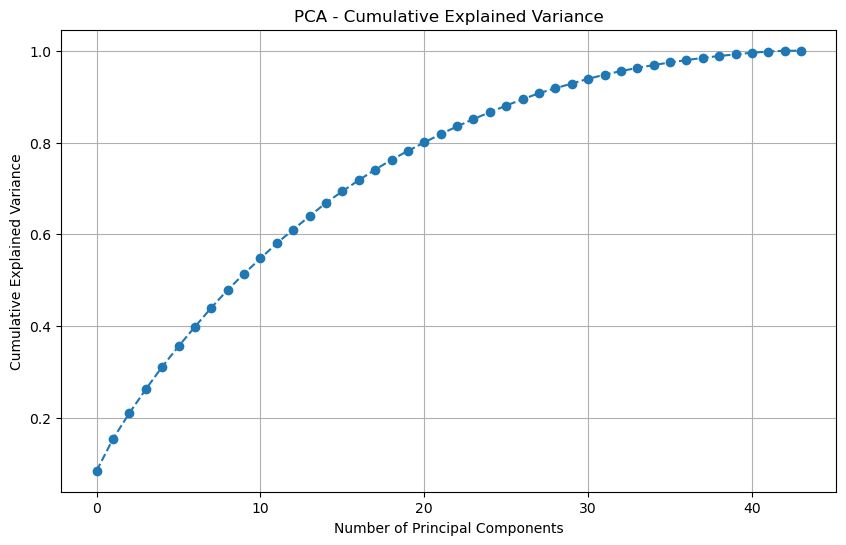

In [ ]:
explained_variance_corr, loadings_corr, features_corr = process_PCA(reduced_data_corr)

In [ ]:
# Create a DataFrame for the loadings
loading_df_corr = pd.DataFrame(loadings_corr.T, columns=[f'PC{i+1}' for i in range(loadings_corr.shape[0])], index=features_corr.columns)
loading_df_corr

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_lower,0.012515,0.075785,0.178538,-0.015022,0.018133,0.091393,0.093010,0.056118,0.063775,0.063213,...,0.109069,0.288093,-0.078824,-0.118301,-0.034338,-0.079413,-0.010353,-0.159203,-0.097897,0.181414
13_16800_lower,0.085003,0.034685,0.082188,-0.129187,-0.143437,-0.056636,0.058686,-0.038639,-0.075581,-0.033288,...,0.018781,0.115061,-0.048025,0.018001,0.109772,0.230352,-0.019326,-0.068940,-0.096993,0.368895
13_3000_lower,0.184595,0.215630,-0.046248,-0.056324,-0.040533,0.077118,-0.076838,0.111500,0.005962,0.056313,...,0.005478,-0.013635,-0.182113,0.084389,-0.064611,0.069340,0.111329,0.022287,-0.010525,-0.106709
13_6000_lower,0.063267,0.173413,-0.023608,-0.234535,0.020402,0.150094,0.026739,-0.043895,-0.060016,0.151052,...,-0.081606,0.028635,0.032046,-0.132828,-0.080104,0.045267,-0.070072,-0.174624,0.063192,-0.006690
13_8000_lower,0.057570,0.168437,0.132001,-0.002814,-0.140396,0.132622,0.064632,-0.033019,0.006123,0.102637,...,-0.051680,-0.082044,0.141441,-0.142714,0.059118,0.112400,-0.008998,-0.051050,0.046277,0.090741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48_8000_upper,0.055529,-0.074559,0.045541,-0.053186,-0.066203,-0.152676,-0.282747,-0.038742,-0.152741,0.021464,...,-0.050449,0.049503,-0.036895,0.036577,-0.008075,0.103110,0.005012,-0.072982,-0.032012,-0.039200
53_10000_upper,0.042964,0.041093,-0.107216,0.147488,-0.072788,0.090331,-0.031851,0.196465,-0.240411,-0.066374,...,0.064212,0.004928,0.021262,-0.147112,-0.076308,0.001598,-0.049306,0.027535,0.217139,-0.045575
53_16800_upper,0.144981,0.110035,0.000320,0.073700,0.085964,-0.094514,0.259420,-0.070585,0.005620,0.012917,...,-0.031692,0.017554,-0.052616,0.193125,0.148870,-0.092240,-0.155639,0.156962,0.000289,0.018752


In [ ]:
# Determine the number of components to retain 90% variance
cumulative_variance = np.cumsum(explained_variance_corr)
num_components = np.argmax(cumulative_variance >= 0.9) + 1

# Get the loadings for the selected components
selected_loadings_corr = loadings_corr[:num_components, :]

# Calculate the importance of each feature by summing the absolute values of its loadings across the selected components
feature_importance_corr = np.sum(np.abs(selected_loadings_corr), axis=0)

# Create a DataFrame for feature importance
feature_importance_df_corr = pd.DataFrame({'Feature': features_corr.columns, 'Importance': feature_importance_corr})

# Sort the features by importance
feature_importance_df_corr = feature_importance_df_corr.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features_corr = feature_importance_df_corr.head(200)

top_features_corr

,Feature,Importance
35,48_10000_lower,2.897291
55,23_16800_upper,2.855303
22,33_3000_lower,2.850252
37,48_3000_lower,2.809336
8,18_6000_lower,2.766342
...,...,...
10,23_10000_lower,2.109517
3,13_6000_lower,2.091893
14,23_8000_lower,2.064383
2,13_3000_lower,2.012307


In [ ]:
# Plot the PCA interactive plot
plot_pca_interactive(reduced_data_corr, sensor_id_col='Sensor ID', n_components=2)

# Retain Features

In [ ]:
df_range_delay_all.head()

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,32,765.626263,765.693878,765.640000,765.560000,766.120000,1057.280000,821.200000,1057.626263,1057.440000,...,0.000000,0.0,2787.833333,0.0,0.000000,3099.0,0.000000,0.0,0.0,0.0
1,33,755.000000,779.530612,736.640000,779.275862,755.467532,1024.818182,1035.640000,1024.777778,1025.720000,...,0.000000,0.0,2740.037037,0.0,0.000000,0.0,3073.666667,0.0,3073.4,3074.0
2,34,665.680000,658.920000,675.989247,653.682353,665.240000,969.480000,969.469136,969.520000,969.585859,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,35,861.640000,861.626263,804.320000,861.840000,863.000000,1012.333333,1011.800000,1012.720000,1012.240000,...,2758.652174,0.0,2756.839080,0.0,2778.428571,0.0,0.000000,0.0,0.0,0.0
4,36,743.520000,743.962025,743.360000,743.680000,743.600000,1067.000000,1054.880000,1064.494949,1067.000000,...,2779.000000,0.0,0.000000,0.0,0.000000,3113.0,0.000000,0.0,0.0,0.0


In [ ]:
# Group the merged data by 'Sensor ID'
grouped_data = df_data_v4_1_1.groupby("Sensor ID")

# Function to get unique values of categorical columns for each group
def get_unique_categorical_values(group):
    unique_values = {}
    for column in group.select_dtypes(include=['object']).columns:
        unique_values[column] = group[column].unique().tolist()
    return unique_values

# Apply the function to each group and collect the results
unique_categorical_values = grouped_data.apply(get_unique_categorical_values).to_dict()

unique_categorical_values

{32: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 33: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 34: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 35: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 36: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 37: {'Color of sensor': ['g'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 38: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 39: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 40: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 41: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},


In [ ]:
unique_categorical_values_df = pd.DataFrame.from_dict(unique_categorical_values, orient='index')

# Convert list values to strings and keep Sensor ID as index
unique_categorical_values_df = unique_categorical_values_df.applymap(lambda x: x[0] if isinstance(x, list) else x)
unique_categorical_values_df.reset_index(inplace=True)

# Rename the 'index' column to 'Sensor ID'
unique_categorical_values_df.rename(columns={'index': 'Sensor ID'}, inplace=True)

# Display the updated DataFrame
unique_categorical_values_df.head()

C:\Users\Jihoon.DESKTOP-1HIBMQO\AppData\Local\Temp\ipykernel_6436\718001310.py:4: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Sensor ID,Color of sensor,Sensor Configuration,Surface material
0,32,b,HTR,wood
1,33,b,HTR,wood
2,34,b,HTR,wood
3,35,b,HTR,wood
4,36,b,HTR,wood


In [ ]:
# One-hot encode all the object features
if not unique_categorical_values_df.empty:
    unique_categorical_values_encoded = pd.get_dummies(unique_categorical_values_df, drop_first=True)
else:
    unique_categorical_values_encoded = unique_categorical_values_df


# Convert boolean columns to integers (0 and 1)
unique_categorical_values_encoded["Color of sensor_g"] = unique_categorical_values_encoded["Color of sensor_g"].astype(int)
unique_categorical_values_encoded

,Sensor ID,Color of sensor_g
0,32,0
1,33,0
2,34,0
3,35,0
4,36,0
...,...,...
72,104,1
73,105,0
74,106,1
75,107,1


In [ ]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_range_delay_all, unique_categorical_values_encoded, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper,Color of sensor_g
0,32,765.626263,765.693878,765.640000,765.560000,766.120000,1057.280000,821.200000,1057.626263,1057.440000,...,0.0,2787.833333,0.0,0.000000,3099.0,0.000000,0.0,0.0,0.0,0
1,33,755.000000,779.530612,736.640000,779.275862,755.467532,1024.818182,1035.640000,1024.777778,1025.720000,...,0.0,2740.037037,0.0,0.000000,0.0,3073.666667,0.0,3073.4,3074.0,0
2,34,665.680000,658.920000,675.989247,653.682353,665.240000,969.480000,969.469136,969.520000,969.585859,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0
3,35,861.640000,861.626263,804.320000,861.840000,863.000000,1012.333333,1011.800000,1012.720000,1012.240000,...,0.0,2756.839080,0.0,2778.428571,0.0,0.000000,0.0,0.0,0.0,0
4,36,743.520000,743.962025,743.360000,743.680000,743.600000,1067.000000,1054.880000,1064.494949,1067.000000,...,0.0,0.000000,0.0,0.000000,3113.0,0.000000,0.0,0.0,0.0,0


# Feature Engineering: Upper and Lower bound's Frequency

In [ ]:
# Group by 'Sensor ID' and 'Delay (us)' for lower quartile
grouped_lower_outliers = df_lower_quartile.groupby(['Sensor ID', 'Delay (us)'])['Ping Time (us)'].count().reset_index()

# Group by 'Sensor ID' and 'Delay (us)' for upper quartile
grouped_upper_outliers = df_upper_quartile.groupby(['Sensor ID', 'Delay (us)'])['Ping Time (us)'].count().reset_index()

# Merge the grouped dataframes with alias column names for the count columns
df_outlier_freq = pd.merge(grouped_lower_outliers, grouped_upper_outliers, on=['Sensor ID', 'Delay (us)'], suffixes=('_lower', '_upper'), how='left')

# Rename the columns if necessary
df_outlier_freq.rename(columns={
    'Ping Time (us)_lower': 'Lower Quartile Ping Count',
    'Ping Time (us)_upper': 'Upper Quartile Ping Count'
}, inplace=True)


# Replace NaN values with 0
df_outlier_freq.fillna(0, inplace=True)

df_outlier_freq['Lower Quartile Ping Count'] = df_outlier_freq['Lower Quartile Ping Count'].astype(int)
df_outlier_freq['Upper Quartile Ping Count'] = df_outlier_freq['Upper Quartile Ping Count'].astype(int)


# Display the resulting DataFrame
df_outlier_freq.head()

,Sensor ID,Delay (us),Lower Quartile Ping Count,Upper Quartile Ping Count
0,32,3000,78,106
1,32,6000,5,0
2,32,8000,39,9
3,32,10000,25,8
4,32,16800,10,1


In [ ]:
df_outlier_freq['delay_freq'] =  "delay"+ '_' + df_outlier_freq['Delay (us)'].astype(str)+'_'+"lower"

# Step 3: Pivot the table
df_pivot_lower = df_outlier_freq.pivot(index='Sensor ID', columns='delay_freq', values='Lower Quartile Ping Count').reset_index()

df_pivot_lower.head()

delay_freq,Sensor ID,delay_10000_lower,delay_16800_lower,delay_3000_lower,delay_6000_lower,delay_8000_lower
0,32,25.0,10.0,78.0,5.0,39.0
1,33,176.0,99.0,79.0,121.0,109.0
2,34,1.0,45.0,112.0,192.0,22.0
3,35,100.0,10.0,82.0,112.0,203.0
4,36,100.0,13.0,97.0,165.0,103.0


In [ ]:
df_outlier_freq['delay_freq'] =  "delay"+ '_' + df_outlier_freq['Delay (us)'].astype(str)+'_'+"upper"

# Step 3: Pivot the table
df_pivot_upper = df_outlier_freq.pivot(index='Sensor ID', columns='delay_freq', values='Upper Quartile Ping Count').reset_index()

df_pivot_upper.head()

delay_freq,Sensor ID,delay_10000_upper,delay_16800_upper,delay_3000_upper,delay_6000_upper,delay_8000_upper
0,32,8.0,1.0,106.0,0.0,9.0
1,33,195.0,82.0,110.0,119.0,141.0
2,34,27.0,35.0,103.0,191.0,15.0
3,35,100.0,16.0,110.0,89.0,196.0
4,36,99.0,33.0,81.0,180.0,93.0


In [ ]:
df_delay_freq = pd.merge(df_pivot_lower,df_pivot_upper, on='Sensor ID',how='left')
# Replace NaN values with 0
df_delay_freq.fillna(0, inplace=True)
df_delay_freq = df_delay_freq.astype(int)

df_delay_freq

delay_freq,Sensor ID,delay_10000_lower,delay_16800_lower,delay_3000_lower,delay_6000_lower,delay_8000_lower,delay_10000_upper,delay_16800_upper,delay_3000_upper,delay_6000_upper,delay_8000_upper
0,32,25,10,78,5,39,8,1,106,0,9
1,33,176,99,79,121,109,195,82,110,119,141
2,34,1,45,112,192,22,27,35,103,191,15
3,35,100,10,82,112,203,100,16,110,89,196
4,36,100,13,97,165,103,99,33,81,180,93
...,...,...,...,...,...,...,...,...,...,...,...
72,104,47,11,122,102,42,73,43,131,90,47
73,105,79,22,40,85,119,81,15,51,104,134
74,106,134,3,163,227,153,136,13,126,222,132
75,107,45,4,133,93,122,48,24,134,86,130


In [ ]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_all, df_delay_freq, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,delay_10000_lower,delay_16800_lower,delay_3000_lower,delay_6000_lower,delay_8000_lower,delay_10000_upper,delay_16800_upper,delay_3000_upper,delay_6000_upper,delay_8000_upper
0,32,765.626263,765.693878,765.640000,765.560000,766.120000,1057.280000,821.200000,1057.626263,1057.440000,...,25,10,78,5,39,8,1,106,0,9
1,33,755.000000,779.530612,736.640000,779.275862,755.467532,1024.818182,1035.640000,1024.777778,1025.720000,...,176,99,79,121,109,195,82,110,119,141
2,34,665.680000,658.920000,675.989247,653.682353,665.240000,969.480000,969.469136,969.520000,969.585859,...,1,45,112,192,22,27,35,103,191,15
3,35,861.640000,861.626263,804.320000,861.840000,863.000000,1012.333333,1011.800000,1012.720000,1012.240000,...,100,10,82,112,203,100,16,110,89,196
4,36,743.520000,743.962025,743.360000,743.680000,743.600000,1067.000000,1054.880000,1064.494949,1067.000000,...,100,13,97,165,103,99,33,81,180,93


# Feature Engineering: Add Variability

In [ ]:

def create_range_delay_feature_variability(df_quartile,bound):
    # Step 1: Group and calculate mean
    df_grouped = df_quartile.groupby(['Sensor ID', 'Range (cm)', 'Delay (us)'])['Ping Time (us)'].var().reset_index()

    # Step 2: Create `range_delay` column
    df_grouped['range_delay_var'] = df_grouped['Range (cm)'].astype(str) + '_' + df_grouped['Delay (us)'].astype(str)+'_'+'var'+'_'+bound

    # Step 3: Pivot the table
    df_pivot = df_grouped.pivot(index='Sensor ID', columns='range_delay_var', values='Ping Time (us)').reset_index()
    
    return df_pivot


def feature_engineering_quartile_var(df):
    df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df)
    df_range_delay_middle = create_range_delay_feature_variability(df_middle_quartile,"middle")
    df_range_delay_lower = create_range_delay_feature_variability(df_lower_quartile,"lower")
    df_range_delay_upper = create_range_delay_feature_variability(df_upper_quartile,"upper")

    # List of DataFrames
    df_pivots = [df_range_delay_middle, df_range_delay_lower, df_range_delay_upper]

    # Initialize the merged DataFrame with the first DataFrame in the list
    df_range_delay_all = df_pivots[0]

    # Iteratively merge each DataFrame in the list
    for df in df_pivots[1:]:
        df_range_delay_all = df_range_delay_all.merge(df, on='Sensor ID')
        
    # Replace all NaN values with 0 in the merged DataFrame
    df_range_delay_all.fillna(0, inplace=True)

    return df_range_delay_all, df_range_delay_middle, df_range_delay_lower,df_range_delay_upper
    

df_range_delay_var_all,df_range_delay_var_middle, df_range_delay_var_lower,df_range_var_delay_upper = feature_engineering_quartile_var(df_data_v4_1_1)


In [ ]:
df_range_delay_var_all.head()

range_delay_var,Sensor ID,13_10000_var_middle,13_16800_var_middle,13_3000_var_middle,13_6000_var_middle,13_8000_var_middle,18_10000_var_middle,18_16800_var_middle,18_3000_var_middle,18_6000_var_middle,...,48_10000_var_upper,48_16800_var_upper,48_3000_var_upper,48_6000_var_upper,48_8000_var_upper,53_10000_var_upper,53_16800_var_upper,53_3000_var_upper,53_6000_var_upper,53_8000_var_upper
0,32,8.216038,6.523880,6.858990,7.602424,6.328889,4.607677,108061.212121,4.950732,4.814545,...,0.000000,0.0,2.753623,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,33,0.000000,7.468125,6.495354,9.969527,3.778537,8.905380,161.525657,9.541950,6.749091,...,0.000000,0.0,3.111111,0.0,0.000000,0.0,21.333333,0.0,4.8,8.0
2,34,129.310707,120.559192,7.880318,5.100280,135.861010,5.100606,6.227160,6.353131,7.612451,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,35,5.242828,4.297671,4.543030,3.327677,0.000000,6.857143,6.141414,6.223838,7.012525,...,64.580984,0.0,30.811013,0.0,7.032967,0.0,0.000000,0.0,0.0,0.0
4,36,6.676364,6.652386,7.788283,7.128889,7.232323,0.000000,212.510707,8.681097,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,4.8,0.000000,0.0,0.0,0.0


In [ ]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_all, df_range_delay_var_all, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_var_upper,48_16800_var_upper,48_3000_var_upper,48_6000_var_upper,48_8000_var_upper,53_10000_var_upper,53_16800_var_upper,53_3000_var_upper,53_6000_var_upper,53_8000_var_upper
0,32,765.626263,765.693878,765.640000,765.560000,766.120000,1057.280000,821.200000,1057.626263,1057.440000,...,0.000000,0.0,2.753623,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,33,755.000000,779.530612,736.640000,779.275862,755.467532,1024.818182,1035.640000,1024.777778,1025.720000,...,0.000000,0.0,3.111111,0.0,0.000000,0.0,21.333333,0.0,4.8,8.0
2,34,665.680000,658.920000,675.989247,653.682353,665.240000,969.480000,969.469136,969.520000,969.585859,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,35,861.640000,861.626263,804.320000,861.840000,863.000000,1012.333333,1011.800000,1012.720000,1012.240000,...,64.580984,0.0,30.811013,0.0,7.032967,0.0,0.000000,0.0,0.0,0.0
4,36,743.520000,743.962025,743.360000,743.680000,743.600000,1067.000000,1054.880000,1064.494949,1067.000000,...,0.000000,0.0,0.000000,0.0,0.000000,4.8,0.000000,0.0,0.0,0.0


In [ ]:
df_all["Sensor ID"].unique()

array([ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
      dtype=int64)

## Export data

In [ ]:
df_all.to_csv("../merged_dataset/data_v4-1-1_feature_engineered.csv", index=False)

# Clustering

In [ ]:
from sklearn.cluster import KMeans

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(reduced_data_corr.drop(columns=['Sensor ID']))
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
principal_df['Sensor ID'] = reduced_data_corr['Sensor ID']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
principal_df['Cluster'] = kmeans.fit_predict(principal_df[['PC1', 'PC2', 'PC3']])

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    principal_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    symbol='Sensor ID',
    title='K-Means Clustering of Sensors Using PCA',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    hover_data=['Sensor ID']
)

fig.show()

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

